## Example 3: Bayesian image deconvolution

We show now an example that IPLA is effective in complex high-dimensional scenarios. We consider the Bayesian Image Deconvolution problem inspired by Experiment 1 in  Durmus, Moulines and Pereyra (2018, Subsection 4.1.2). Given a high-resolution grayscale image $x \in \mathbb{R}^d$ such that $d = n \times n=600 \times 600$, the goal of the problem is to recover image $x$ from a blurred image. Namely, we are to sample from posterior density $p(x|y)$ of blurred image with additive noise (observation) such that 
$$
y = Hx + W \ \textup{ for }\ W \sim \mathcal{N} (0, \sigma^2 \mathsf{Id}) \, ,
$$
where $H$ is a circulant blur matrix representing 2D discrete convolution and $W$ is an additive noise. 

We need to define 2D discrete isotropic total variation via
$$
TV(x) := \sum_{i,j = 1}^{n-1} \sqrt{|x_{in, j+1}-x_{in, j}|^2+|x_{(i+1)n, j}-x_{in, j}|^2} 
 + \sum_{j = 1}^{n-1}|x_{nd, j+1}-x_{nd, j}| + \sum_{i = 1}^{n-1}|x_{(i+1)n, n}-x_{in, n}| \,,
$$

which was proposed  in the context of image processing by \citet{ROC_model}. Note that $TV$ is a~discretization of the standard total variation norm, cf. Chambolle (2004, Section 2).

We choose prior distribution $p(x) \propto \exp (-\beta \, TV(x))$, where $\beta > 0$ is  a regularizing factor. Henceforth, we provide sampling from the posterior distribution $\mu^*:=p(x|y)$ satisfying 
$$
\mu^* \propto \exp \Big(-\tfrac{1}{2\sigma^2}|y - Hx|^2 - \beta \, TV(x) \Big) \, .
$$
Even if $TV$ is not smooth, and consequently the theoretical convergence rates are not known for IPLA, TULA, or ULA, we show the performance of our algorithm. It might be expected that the inexact proximal step could be non-trivial in this case.  Nonetheless, it can be effectively solved with the use of the Adaptive Primal--Dual Hybrid Algorithm by Goldstein, Li and Yuan (2015, Algorithm 1). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mi
from tqdm import tqdm
from skimage import data
import pylops
import pyproximal
from L2_MC import L2_MC
import imageio.v3 as iio
import my_primal_dual

#### Load original (unknown) picture

Text(0.5, 1.0, 'original image')

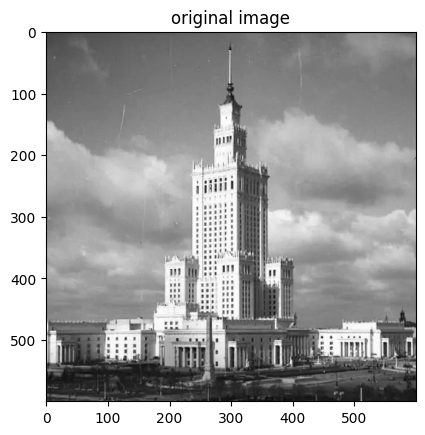

In [2]:
img = iio.imread("urbanity.jpg") [50:650, 150:750, 0]
ny, nx = img.shape

# show picture
plt.figure()
plt.imshow(img, cmap="grey")
plt.title("original image")

#### Create blurred picture (observation)

Text(0.5, 1.0, 'blurred image')

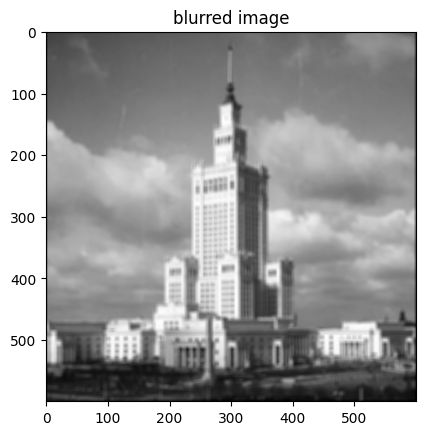

In [3]:
sigma=0.5
depth = 7

# CREATE BLUR MATRIX
h = np.ones((depth, depth))
h /= h.sum()
nh = h.shape
H = pylops.signalprocessing.Convolve2D((ny, nx), h=h, offset=(nh[0] // 2, nh[1] // 2))

# CREATE BLURRED FIGURE
y = H * img + np.random.normal(loc=0, scale=sigma, size=(ny, nx))

# show blurred figure

plt.figure()
plt.imshow(y.reshape(img.shape), cmap="grey")
plt.title("blurred image")

#### Calculate the mean of the posterior distribution

Adaptive Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau0 = 4.000000e+03	mu0 = 3.809524e+03
alpha0 = 5.000000e-01	eta = 9.500000e-01
s = 1.000000e+00	delta = 1.500000e+00
niter = 5000		tol = 1.000000e-01

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     2   3.14439e+01   4.397e+06   4.794e+04   0.000e+00       4.445e+06
     3   3.83435e+01   2.189e+06   5.630e+04   0.000e+00       2.245e+06
     4   3.96512e+01   1.458e+06   5.923e+04   0.000e+00       1.517e+06
     5   4.18244e+01   1.162e+06   6.314e+04   0.000e+00       1.226e+06
     6   4.24542e+01   9.531e+05   6.554e+04   0.000e+00       1.019e+06
     7   4.36794e+01   8.369e+05   6.781e+04   0.000e+00       9.047e+05
     8  

Text(0.5, 1.0, 'processed image modus')

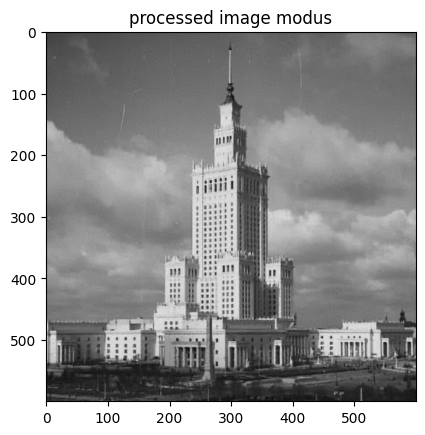

In [ ]:
# Set up parameters of the optimization algorithm
max_eig_HTH = 1.05 # upper estimate 
tau0 = 4000
mu0 = tau0/max_eig_HTH

# set up parameters of the posterior distribution 
beta = 0.03

l1iso = pyproximal.L21(ndim=2, sigma= beta)

# Gradient operator
Gop = pylops.Gradient(
    dims=(ny, nx), 
    sampling=1., 
    edge=False, 
    kind='forward', 
    dtype='float64'
    )

# L2 data term
l2_5 = pyproximal.L2(Op=H, b=y.ravel(), sigma=1/sigma**2,  warm=True)

x0 = np.zeros(img.ravel().shape)
result = pyproximal.optimization.primaldual.AdaptivePrimalDual(l2_5, l1iso, Gop, tau=tau0, mu=mu0,niter=5 000,
                                                         x0=x0, tol=0.1, show=True)

img_modus = result[0].reshape(img.shape)

# show processed image : MODUS
plt.figure()
plt.imshow(img_modus, cmap="grey")
plt.title("processed image modus")


#### Sampling

In [5]:
# parameters of the posterior distribution
beta = 0.03
sigma=0.5
depth = 7

# CREATE BLUR MATRIX
h = np.ones((depth, depth))
h /= h.sum()
nh = h.shape
H = pylops.signalprocessing.Convolve2D((ny, nx), h=h, offset=(nh[0] // 2, nh[1] // 2))

# Parameters of the optimization algorithm
max_eig_HTH = 1.05 # let us say we know it :) it is upper empirical estimate 
tau0 = 5000
mu0 = tau0/max_eig_HTH

Gop = pylops.Gradient(dims=(ny, nx), sampling=1., edge=False, kind='forward', dtype='float64')
# L2 data term
time_step = 0.001
l2 = L2_MC(Op=H, b=y.ravel(), sigma=2,  warm=True, time_step=time_step, v=img_modus.ravel())
x0 = img_modus.ravel()

samples_implicit = [img_modus.ravel()]

n_MC = 3000
burn_in = 100


for i_MC in tqdm(range(0, burn_in+n_MC)):

    l2.v=samples_implicit[-1]

    result_prox = pyproximal.optimization.primaldual.AdaptivePrimalDual(
        l2, l1iso, Gop, tau=tau0, mu=mu0, niter=50, x0=samples_implicit[-1], tol=0.1, show=False)[0]
    
    result_step = result_prox + np.random.normal(loc=0, scale=np.sqrt(2*time_step), size=nx*ny)

    samples_implicit.append(result_step)

samples_implicit = np.array(samples_implicit[burn_in:])

output_mean = np.mean(samples_implicit, axis=0)

output_median = np.median(samples_implicit, axis=0)

100%|██████████| 3100/3100 [05:34<00:00,  9.26it/s]


#### Show the results

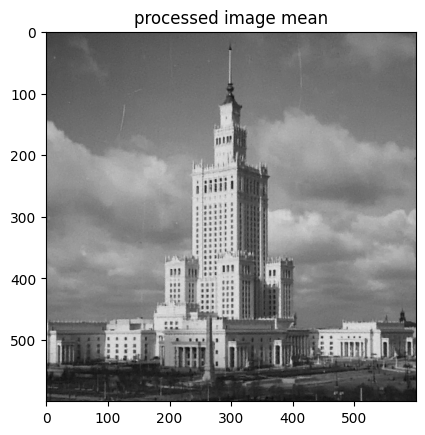

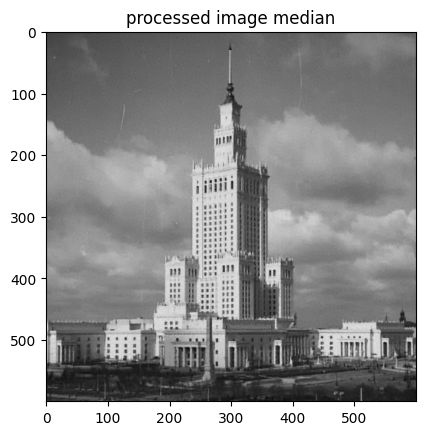

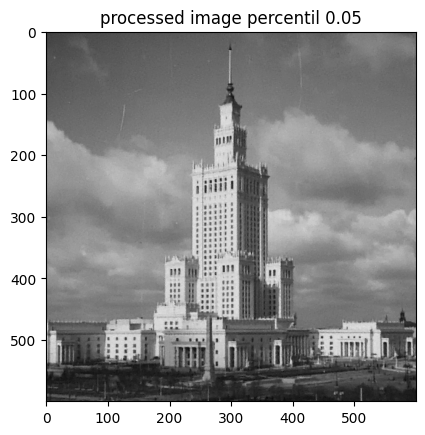

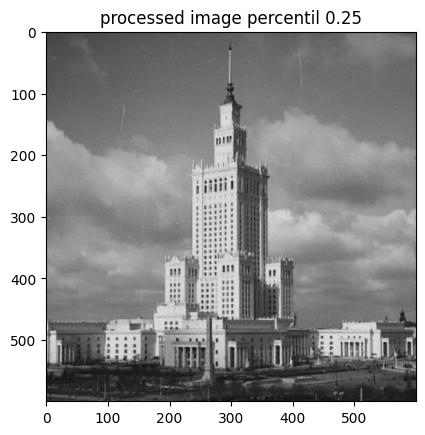

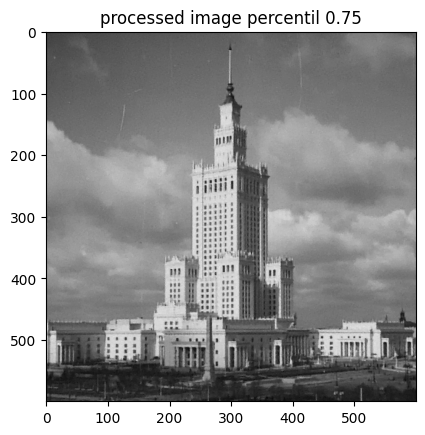

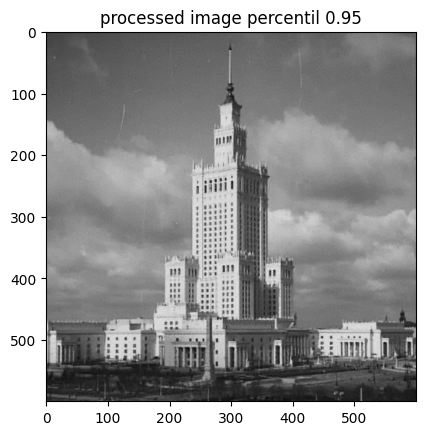

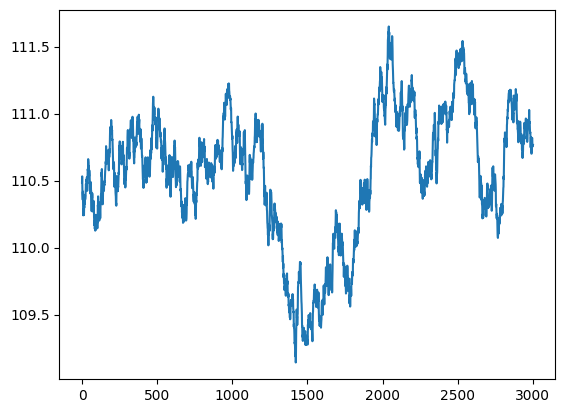

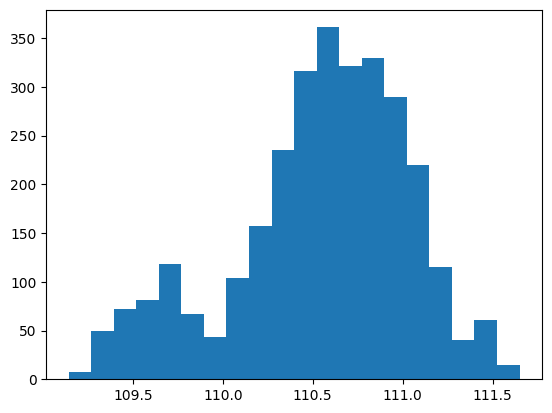

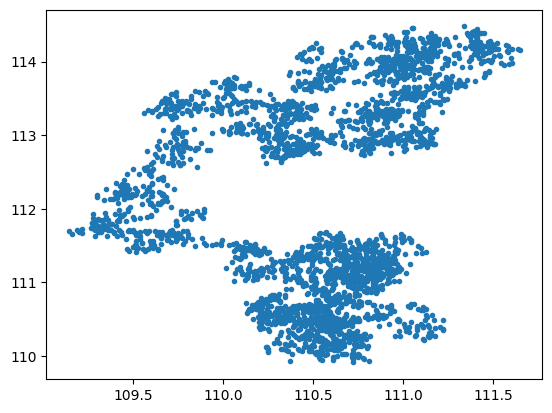

In [6]:
# mean
img_proc_mean = output_mean.reshape(img.shape)
plt.figure()
plt.imshow(img_proc_mean, cmap="grey")
plt.title("processed image mean")

# median 
img_proc_median = output_median.reshape(img.shape)
plt.figure()
plt.imshow(img_proc_median, cmap="grey")
plt.title("processed image median")

# sleected percentils
img_perc_005 = np.percentile(samples_implicit, 0.05, axis=0).reshape(img.shape)
plt.figure()
plt.imshow(img_perc_005, cmap="grey")
plt.title("processed image percentil 0.05")

img_perc_025 = np.percentile(samples_implicit, 0.25, axis=0).reshape(img.shape)
plt.figure()
plt.imshow(img_perc_025, cmap="grey")
plt.title("processed image percentil 0.25")

img_perc_075 = np.percentile(samples_implicit, 0.75, axis=0).reshape(img.shape)
plt.figure()
plt.imshow(img_perc_075, cmap="grey")
plt.title("processed image percentil 0.75")

img_perc_095 = np.percentile(samples_implicit, 0.95, axis=0).reshape(img.shape)
plt.figure()
plt.imshow(img_perc_095, cmap="grey")
plt.title("processed image percentil 0.95")

# trajectory of selected coordinate
coord = 10000
plt.figure()
plt.plot(np.arange(0,len(samples_implicit[:,coord])), samples_implicit[:,coord])

# histogram of selected coordinate
plt.figure()
plt.hist(samples_implicit[:,coord], bins = 20)

# scatter plot of selected coordinate and coordinate+1
plt.figure()
plt.plot(samples_implicit[:,coord], samples_implicit[:,coord+1], ".")